<a href="https://colab.research.google.com/github/shaunahan/projects/blob/main/NLP__Spooky_Author_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal of the exercise is to identify the author of the sentences in the test set.
1. The dataset contains text from works of fiction written by spooky authors of the public domain:

Edgar Allan Poe (EAP)
HP Lovecraft (HPL)
Mary Wollstonecraft Shelley (MWS)

In [3]:
!pip install nltk

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [6]:
## Read the train and test dataset 
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# Read the train and test dataset 
train_df = pd.read_csv("train_spooky.csv")
test_df = pd.read_csv("test_spooky.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Mounted at /content/drive
Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [7]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Check the number of occurance for each author. (balanced number of data between authors)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


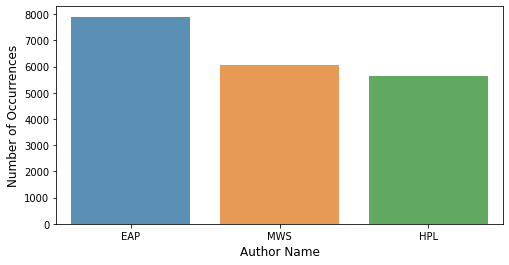

In [8]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

## Feature Engineering:

1. Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
2. Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

### 1. Meta Features

In [9]:
# Number of words in the text 
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

# Number of unique words in the text 
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the text 
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

# Number of stopwords in the text 
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Number of punctuations in the text 
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# Number of title case words in the text 
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the text 
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words in the text 
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

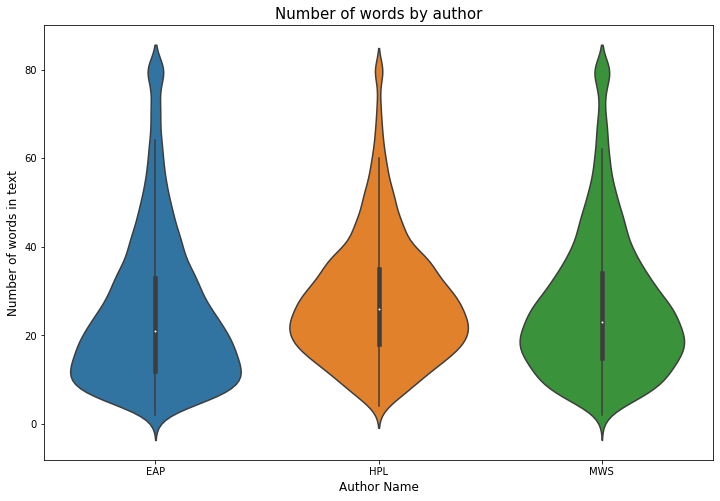

In [10]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

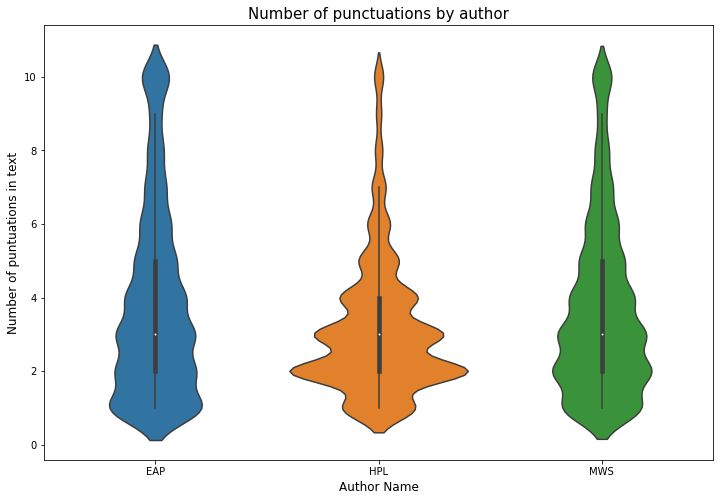

In [11]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [12]:
# Prepare the data for modeling 
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# recompute the trauncated variables  
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

#### Train a simple XGBoost model with these meta features.

In [13]:
#train a XGBoost Model

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

Check the first fold in the k-fold cross validation for the scores

In [14]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.0937	test-mlogloss:1.09453
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04138	test-mlogloss:1.05172
[40]	train-mlogloss:1.02343	test-mlogloss:1.03983
[60]	train-mlogloss:1.01043	test-mlogloss:1.03051
[80]	train-mlogloss:1.00001	test-mlogloss:1.02301
[100]	train-mlogloss:0.992056	test-mlogloss:1.01754
[120]	train-mlogloss:0.983985	test-mlogloss:1.01192
[140]	train-mlogloss:0.977474	test-mlogloss:1.00829
[160]	train-mlogloss:0.972334	test-mlogloss:1.00502
[180]	train-mlogloss:0.967121	test-mlogloss:1.00192
[200]	train-mlogloss:0.962841	test-mlogloss:1.00031
[220]	train-mlogloss:0.959004	test-mlogloss:0.999193
[240]	train-mlogloss:0.954595	test-mlogloss:0.997093
[260]	train-mlogloss:0.951285	test-mlogloss:0.99559
[280]	train-mlogloss:0.94809	test-mlogloss:0.994533
[300]	train-mlogloss:0.945068	test-mlogloss:0.993919
[320]	train-mlogloss:0.942

CV score of 0.989


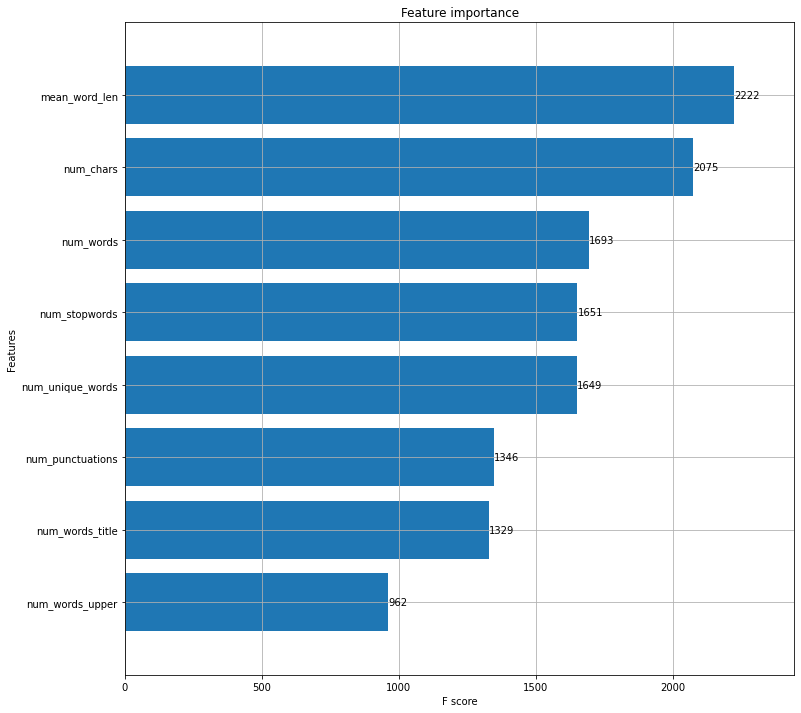

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Number of characters, mean word length and number of unique words turn out to be the top 3 variables. 

### Vectorize data using vectoizers

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
train_df = pd.read_csv('train_spooky.csv')
test_df = pd.read_csv('test_spooky.csv')

In [22]:
# Examine the data
train_df['author'].value_counts()
train_df['text_length'] = train_df['text'].str.len()

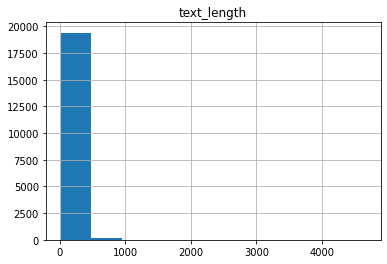

In [23]:
train_df.hist()
plt.show()

Most of the text length are 500 characters and less.

In [25]:
EAP = train_df[train_df['author'] =='EAP']['text_length']
EAP.describe()


count    7900.000000
mean      142.225949
std       105.751334
min        21.000000
25%        68.000000
50%       115.000000
75%       186.000000
max      1533.000000
Name: text_length, dtype: float64

In [26]:
MWS = train_df[train_df['author'] == 'MWS']['text_length']
MWS.describe()

count    6044.000000
mean      151.659828
std       126.305008
min        21.000000
25%        84.000000
50%       130.000000
75%       192.000000
max      4663.000000
Name: text_length, dtype: float64

In [27]:
HPL = train_df[train_df['author'] == 'HPL']['text_length']
HPL.describe()

count    5635.000000
mean      155.843478
std        82.020647
min        21.000000
25%        98.000000
50%       142.000000
75%       196.500000
max       900.000000
Name: text_length, dtype: float64

In [28]:
# Examine test dataset

# text characters length in test_df 
test_df['text_length'] = test_df['text'].str.len()

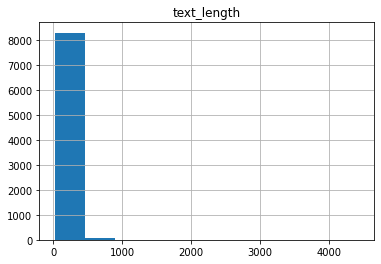

In [29]:
test_df.hist()
plt.show()

The proportion of text which are long in the test data is very similar to that in the train data

#### Preprocess the dataset

In [31]:
# convert author labels into numerical variables
train_df['author_num'] = train_df.author.map({'EAP':0, 'HPL':1, 'MWS':2})
# Check conversion for first 5 rows
train_df.head()

#limit text length to 700 characters to reduce outliers

train_df = train_df.rename(columns={'text':'original_text'})
train_df['text'] = train_df['original_text'].str[:700]
train_df['text_length'] = train_df['text'].str.len()

test_df = test_df.rename(columns={'text':'original_text'})
test_df['text'] = test_df['original_text'].str[:700]
test_df['text_length'] = test_df['text'].str.len()

In [34]:
# define X and y in train data

X = train_df['text']
y = train_df['author_num']

# split train data into a training and a test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# examine the class distribution in y_train and y_test
print(y_train.value_counts(),'\n', y_test.value_counts())

(15663,) (15663,) (3916,) (3916,)
0    6330
2    4800
1    4533
Name: author_num, dtype: int64 
 0    1570
2    1244
1    1102
Name: author_num, dtype: int64


In [35]:
#vectorize the data using Vectorizer

# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# vect = CountVectorizer()
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b')
vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\;|\:')
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\?|\;|\:|\!|\'')
vect

CountVectorizer(lowercase=False, token_pattern='(?u)\\b\\w+\\b|\\,|\\.|\\;|\\:')

In [38]:
# learn the vocabulary in the training data
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm

<15663x25149 sparse matrix of type '<class 'numpy.int64'>'
	with 390889 stored elements in Compressed Sparse Row format>

In [39]:
# transform the test data using the earlier fitted vocabulary
X_test_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_dtm

<3916x25149 sparse matrix of type '<class 'numpy.int64'>'
	with 94477 stored elements in Compressed Sparse Row format>

In [40]:
# Add character counts as a features to the sparse matrix using function
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [41]:
from string import punctuation
X_train_chars = X_train.str.len()
X_train_punc = X_train.apply(lambda x: len([c for c in str(x) if c in punctuation]))
X_test_chars = X_test.str.len()
X_test_punc = X_test.apply(lambda x: len([c for c in str(x) if c in punctuation]))
X_train_dtm = add_feature(X_train_dtm, [X_train_chars, X_train_punc])
X_test_dtm = add_feature(X_test_dtm, [X_test_chars, X_test_punc])

In [43]:
X_train_dtm
X_test_dtm

<3916x25151 sparse matrix of type '<class 'numpy.longlong'>'
	with 102308 stored elements in Compressed Sparse Row format>

In [45]:
#Build and evaluate an author classification model using Multinomial Naive Bayes

# import and instantiate the Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb

# tune hyperparameter alpha = [0.01, 0.1, 1, 10, 100]
from sklearn.model_selection import GridSearchCV
grid_values = {'alpha':[0.01, 0.1, 1.0, 10.0, 100.0]}
grid_nb = GridSearchCV(nb, param_grid=grid_values, scoring='neg_log_loss')
grid_nb.fit(X_train_dtm, y_train)
grid_nb.best_params_

{'alpha': 1.0}

In [46]:
# set with recommended hyperparameters
nb = MultinomialNB(alpha=1.0)
# train the model using X_train_dtm & y_train
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [47]:
# make author (class) predictions for X_test_dtm
y_pred_test = nb.predict(X_test_dtm)

In [52]:
# compute the accuracy of the predictions with y_test
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_test)

# compute the accuracy of training data predictions
y_pred_train = nb.predict(X_train_dtm)
metrics.accuracy_score(y_train, y_pred_train)

# look at the confusion matrix for y_test
metrics.confusion_matrix(y_test, y_pred_test)

# calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)
y_pred_prob[:10]

# compute the log loss number
metrics.log_loss(y_test, y_pred_prob)

0.4526353464718414

#### Build and evaluate an author classification model using logistic regression


In [54]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=8)
logreg

# tune hyperparameter
grid_values = {'C':[0.01, 0.1, 1.0, 3.0, 5.0]}
grid_logreg = GridSearchCV(logreg, param_grid=grid_values, scoring='neg_log_loss')
grid_logreg.fit(X_train_dtm, y_train)
grid_logreg.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'C': 5.0}

In [60]:
# set with recommended parameter
logreg = LogisticRegression(C=1.0, random_state=8)
# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)

# compute the accuracy of the predictions
metrics.accuracy_score(y_test, y_pred_test)

# compute the accuracy of predictions with the training data
y_pred_train = logreg.predict(X_train_dtm)
metrics.accuracy_score(y_train, y_pred_train)

# look at the confusion matrix for y_test
metrics.confusion_matrix(y_test, y_pred_test)

# compute the predicted probabilities for X_test_dtm
y_pred_prob = logreg.predict_proba(X_test_dtm)
y_pred_prob[:10]

# compute the log loss number
metrics.log_loss(y_test, y_pred_prob)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7317106996884598

In [61]:
# Learn the vocabulary in the entire training data
X_dtm = vect.fit_transform(X)
# Examine the document-term matrix created from X_train
X_dtm

# Add character counts features
X_chars = X.str.len()
X_punc = X.apply(lambda x: len([c for c in str(x) if c in punctuation]))
X_dtm = add_feature(X_dtm, [X_chars, X_punc])
X_dtm

# Train the Logistic Regression model using X_dtm & y
logreg.fit(X_dtm, y)

# Compute the accuracy of training data predictions
y_pred_train = logreg.predict(X_dtm)
metrics.accuracy_score(y, y_pred_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7037642371929108

In [64]:
#Train the logistic model with the entire dataset "train.csv"

test = test_df['text']
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_dtm = vect.transform(test)
# examine the document-term matrix from X_test
test_dtm

# Add character counts features
test_chars = test.str.len()
test_punc = test.str.count(r'\W')
test_dtm = add_feature(test_dtm, [test_chars, test_punc])
test_dtm

# make author (class) predictions for test_dtm
LR_y_pred = logreg.predict(test_dtm)
print(LR_y_pred)

# calculate predicted probabilities for test_dtm
LR_y_pred_prob = logreg.predict_proba(test_dtm)
LR_y_pred_prob[:10]

[0 0 0 ... 0 0 0]


array([[9.88193431e-01, 1.05197871e-02, 1.28678217e-03],
       [9.99998638e-01, 1.36201030e-06, 1.33348826e-13],
       [8.69845597e-01, 1.30145075e-01, 9.32806623e-06],
       [9.99813806e-01, 1.86180423e-04, 1.33875443e-08],
       [8.69427630e-01, 1.00948997e-01, 2.96233733e-02],
       [9.99950906e-01, 4.90545629e-05, 3.91367580e-08],
       [9.98022774e-01, 1.74882614e-03, 2.28399595e-04],
       [9.66130663e-01, 3.37023439e-02, 1.66992979e-04],
       [9.99377568e-01, 6.22114661e-04, 3.17636613e-07],
       [9.61362532e-01, 2.55942562e-02, 1.30432116e-02]])

In [66]:
# train the Naive Bayes model with the entire dataset "train.csv"

nb.fit(X_dtm, y)

# compute the accuracy of training data predictions
y_pred_train = nb.predict(X_dtm)
metrics.accuracy_score(y, y_pred_train)

#make predictions on test data
NB_y_pred = nb.predict(test_dtm)
print(NB_y_pred)

# calculate predicted probablilities for test_dtm
NB_y_pred_prob = nb.predict_proba(test_dtm)
NB_y_pred_prob[:10]

[2 0 0 ... 0 2 0]


array([[1.07498591e-02, 7.58565047e-07, 9.89249382e-01],
       [1.00000000e+00, 8.91398603e-16, 2.87596702e-12],
       [9.95430753e-01, 4.55817237e-03, 1.10750519e-05],
       [9.99999809e-01, 1.87870429e-07, 2.75662689e-09],
       [9.90005669e-01, 2.33137445e-04, 9.76119392e-03],
       [9.99999878e-01, 5.40447643e-08, 6.76049106e-08],
       [9.99295550e-01, 2.74130306e-04, 4.30319506e-04],
       [1.50533210e-03, 5.49886522e-07, 9.98494118e-01],
       [9.99999996e-01, 3.52726854e-09, 2.18361865e-11],
       [9.87811244e-01, 6.03281072e-04, 1.15854745e-02]])

In [70]:
 # combine the probabilities from the two models

 alpha = 0.6
y_pred_prob = ((1-alpha)*LR_y_pred_prob + alpha*NB_y_pred_prob)
y_pred_prob[:10]

result = pd.DataFrame(y_pred_prob, columns=['EAP','HPL','MWS'])
result.insert(0, 'id', test_df['id'])
result.head()

,id,EAP,HPL,MWS
0,id02310,0.401727,4.208370e-03,5.940643e-01
1,id24541,0.999999,5.448041e-07,1.778920e-12
2,id00134,0.945197,5.479293e-02,1.037626e-05
3,id27757,0.999925,7.458489e-05,7.008994e-09
4,id04081,0.941774,4.051948e-02,1.770607e-02


### Exploring sklearn pipelines

In [72]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('train_spooky.csv')

df.dropna(axis=0)
df.set_index('id', inplace = True)

df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [73]:
import re
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
def processing(df):
    #lowering and removing punctuation
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    
    #numerical feature engineering
    #total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    #get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    #get the average word length
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    #get the average word length
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    return(df)

df = processing(df)

df.head()

,text,author,processed,length,words,words_not_stopword,avg_word_length,commas
id,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,224,41,21,6.380952,4
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,70,14,6,6.166667,0
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,195,36,19,5.947368,4
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,202,34,21,6.476190,3
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,170,27,16,7.187500,2


In [74]:
#create a pipeline.

from sklearn.model_selection import train_test_split

features= [c for c in df.columns.values if c  not in ['id','text','author']]
numeric_features= [c for c in df.columns.values if c  not in ['id','text','author','processed']]
target = 'author'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)
X_train.head()

,processed,length,words,words_not_stopword,avg_word_length,commas
id,,,,,,
id19417,this panorama is indeed glorious and i should ...,91,18,6,6.666667,1
id09522,there was a simple natural earnestness about h...,240,44,18,6.277778,4
id22732,who are you pray that i duc de lomelette princ...,387,74,38,5.552632,9
id10351,he had gone in the carriage to the nearest tow...,118,24,11,5.363636,0
id24580,there is no method in their proceedings beyond...,71,13,5,7.000000,1


### Preprocess the data


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

text = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

text.fit_transform(X_train)

from sklearn.preprocessing import StandardScaler

length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', StandardScaler())
            ])

length.fit_transform(X_train)

array([[-0.50769254],
       [ 0.88000324],
       [ 2.24907223],
       ...,
       [-0.46112557],
       [-0.14447015],
       [-0.39593181]])

In [78]:
words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])
words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', StandardScaler())
            ])
avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])
commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', StandardScaler()),
            ])

In [79]:
#make a pipeline from all of our pipelines

from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<13117x21521 sparse matrix of type '<class 'numpy.float64'>'
	with 213646 stored elements in Compressed Sparse Row format>

In [80]:
#calculate raw accuracy

from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
np.mean(preds == y_test)

0.6792014856081708

In [83]:
#cross validation to find the best pipeline

pipeline.get_params().keys()

from sklearn.model_selection import GridSearchCV

hyperparameters = { 'features__text__tfidf__max_df': [0.9, 0.95],
                    'features__text__tfidf__ngram_range': [(1,1), (1,2)],
                   'classifier__max_depth': [50, 70],
                    'classifier__min_samples_leaf': [1,2]
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 
# Fit and tune model
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='processed')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(stop_words='english'))])),
                                                                       ('length',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='length')),
                                                                                        ('stan

In [84]:
clf.best_params_

#refitting on entire training data using best settings
clf.refit

preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)

np.mean(preds == y_test)

0.6627978953884246

In [85]:
#evaluate on test dataset

submission = pd.read_csv('test_spooky.csv')

#preprocessing
submission = processing(submission)
predictions = clf.predict_proba(submission)

preds = pd.DataFrame(data=predictions, columns = clf.best_estimator_.named_steps['classifier'].classes_)

#generating a submission file
result = pd.concat([submission[['id']], preds], axis=1)
result.set_index('id', inplace = True)
result.head()

,EAP,HPL,MWS
id,,,
id02310,0.282536,0.260946,0.456518
id24541,0.581561,0.189180,0.229259
id00134,0.341303,0.449904,0.208792
id27757,0.528043,0.232676,0.239282
id04081,0.552280,0.196810,0.250910


In [86]:
result.shape

(8392, 3)